[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sjut/HSE-Compling/blob/master/seminars/7_Sentiment.ipynb)

In [1]:
!pip install innvestigate

In [2]:
!pip install tensorflow==1.14.0

In [2]:
import re
import keras.backend
import keras.models
import matplotlib.pyplot as plt
from matplotlib import cm, transforms

import numpy as np
import pandas as pd
import os
import pickle
import time

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [4]:
!wget http://vectors.nlpl.eu/repository/11/180.zip
!unzip 180.zip

--2019-12-12 11:58:44--  http://vectors.nlpl.eu/repository/11/180.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484452285 (462M) [application/zip]
Saving to: ‘180.zip.2’

180.zip.2             0%[                    ]  38.84K   124KB/s               ^C
Archive:  180.zip
replace README? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
!wget https://raw.githubusercontent.com/sjut/HSE-Compling/master/seminars/data/reviews_tok.txt
!wget https://raw.githubusercontent.com/sjut/HSE-Compling/master/seminars/data/reviews_scores.txt

In [0]:
texts = []
with open("reviews_tok.txt") as f:
    for line in f:
        texts.append(line.rstrip('\r\n').split())
scores = []
with open("reviews_scores.txt") as f:
    scores = list(map(lambda x: float(x.rstrip("\r\n")), f.readlines()))

In [4]:
scores = np.array(scores)
binary_scores = scores > 5.
print(binary_scores[0])

True


In [0]:
binary_scores = binary_scores.astype(int)[:2000]

In [0]:
def max_length(texts):
    return max(len(t) for t in texts)

In [7]:
print(len(texts))
print(len(scores))

2994
2994


In [8]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format('model.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from sklearn.model_selection import train_test_split
scores_train, scores_val, texts_train, texts_val = train_test_split(
    binary_scores, texts[:2000], test_size=0.3)

In [0]:
from collections import Counter
from itertools import chain

MAX_LEN = max(max_length(texts_train), max_length(texts_val))

def load_dataset(lines, embedding_dim, num_examples=None):
    prep = lines[:num_examples]
    vocab = Counter()
    x_tensor = np.zeros((len(prep), MAX_LEN, embedding_dim))
    for i, text in enumerate(prep):
        for j, w in enumerate(text):
            try:
                x_tensor[i, j, :] = w2v_model[w]
            except KeyError:
                pass
        vocab[w] += 1
    return x_tensor, vocab

In [0]:
input_tensor_train, inp_vocab_train = load_dataset(texts_train, w2v_model.vector_size)
input_tensor_val, inp_vocab_val = load_dataset(texts_val, w2v_model.vector_size)

In [12]:
w2v_model.vector_size

300

In [13]:
input_tensor_train.shape

(1400, 1791, 300)

In [14]:
scores_train

array([0, 1, 1, ..., 1, 0, 1])

In [0]:
embedding_dim = w2v_model.vector_size
inp_vocab = inp_vocab_train + inp_vocab_val
vocab_inp_size = len(inp_vocab)+1

In [16]:
from innvestigate.utils.tests.networks import base as network_base
def build_network(max_len, voc_size, embedding_dim, output_n, activation=None, dense_unit=256, dropout_rate=0.25):
    if activation:
        activation = "relu"

    net = {}
    net["in"] = keras.Input(shape=[1, max_len, embedding_dim])
    net["conv"] = keras.layers.Conv2D(filters=100, kernel_size=(1,2), strides=(1, 1), padding='valid')(net["in"])
    net["pool"] = keras.layers.MaxPooling2D(pool_size=(1, max_len-1), strides=(1,1))(net["conv"])
    net["out"] = network_base.dense_layer(keras.layers.Flatten()(net["pool"]), units=output_n, activation=activation)
    net["sm_out"] = network_base.softmax(net["out"])


    net.update({
        "input_shape": [1, max_len, embedding_dim],
        "output_n": output_n,
    })
    return net

net = build_network(MAX_LEN, vocab_inp_size, embedding_dim, 2)
model_without_softmax = keras.models.Model(inputs=net['in'], outputs=net['out'])
model_with_softmax = keras.models.Model(inputs=net['in'], outputs=net['sm_out'])

In [17]:
model_without_softmax.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 1791, 300)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1790, 100)      60100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 100)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 60,302
Trainable params: 60,302
Non-trainable params: 0
_________________________________________________________________


In [0]:
def to_one_hot(y):
    return keras.utils.to_categorical(y, 2)

def train_model(model, epochs=20):
    
    x_train = np.expand_dims(input_tensor_train, axis=1)
    y_train = to_one_hot(scores_train)
    
    x_val = np.expand_dims(input_tensor_val, axis=1)
    y_val = to_one_hot(scores_val)

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=256,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val),
                        shuffle=True
                       )

In [19]:
train_model(model_with_softmax, epochs=10)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1400 samples, validate on 600 samples
Epoch 1/10
1400/1400 [==============================] - 14s 10ms/step - loss: 0.8407 - acc: 0.7064 - val_loss: 0.7847 - val_acc: 0.7517
Epoch 2/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.4956 - acc: 0.7979 - val_loss: 0.7547 - val_acc: 0.6967
Epoch 3/10
1400/1400 [==============================] - 12s 9ms/step - loss: 0.3553 - acc: 0.8457 - val_loss: 0.7273 - val_acc: 0.6867
Epoch 4/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.2715 - acc: 0.9071 - val_loss: 0.7715 - val_acc: 0.7517
Epoch 5/10
1400/1400 [==============================] - 12s 9ms/step - loss: 0.2062 - acc: 0.9443 - val_loss: 0.7382 - val_acc: 0.7233
Epoch 6/10
1400/1400 [==============================] - 13s 9ms/step - loss: 0.1609 - acc: 0.9464 - val_loss: 0.7446 - val_acc: 0.7167
Epoch 7/10
1400/1400 [=======================

In [0]:
model_without_softmax.set_weights(model_with_softmax.get_weights())

In [0]:
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'pattern.attribution']
kwargs = [{}, {}, {}, {'pattern_type': 'relu'}]

In [22]:
import innvestigate
analyzers = []

for method, kws in zip(methods, kwargs):
    analyzer = innvestigate.create_analyzer(method, model_without_softmax, **kws)
    analyzer.fit(np.expand_dims(input_tensor_train, axis=1), batch_size=256, verbose=1)
    analyzers.append(analyzer)

Instructions for updating:
ksizes is deprecated, use sizes instead


/usr/local/lib/python3.6/dist-packages/innvestigate/analyzer/base.py:130: RuntimeWarning: This analyzer does not need to be trained. Still fit() is called.
  " Still fit() is called.", RuntimeWarning)


Epoch 1/1
6/6 [==============================] - 18s 3s/step - loss: 2.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000


In [0]:
def analyze_scores(X, Y, ridx):
    max_len = max_length(input_tensor_train)

    analysis = np.zeros([len(analyzers), 1, max_len])
    x, y = X[ridx], Y[ridx]
    t_start = time.time()
    x = x.reshape((1, 1, max_len, embedding_dim))
    presm = model_without_softmax.predict_on_batch(x)[0] #forward pass without softmax
    prob = model_with_softmax.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
  
    for aidx, analyzer in enumerate(analyzers):
        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        analysis[aidx] = a
    t_elapsed = time.time() - t_start
    print('Review %d (%.4fs)'% (ridx, t_elapsed))
    return analysis, y_hat

In [24]:
analyze_scores(input_tensor_train, scores_train, 97)

Review 97 (1.4156s)


(array([[[  0.12803379,  -0.5316264 ,   0.34174576, ...,   0.        ,
            0.        ,   0.        ]],
 
        [[  0.54873919,  -0.1606468 ,   0.        , ...,   0.        ,
            0.        ,   0.        ]],
 
        [[ -0.04620249,  -0.04924273,   0.        , ...,   0.        ,
            0.        ,   0.        ]],
 
        [[-10.77243423,  -9.90139961,  -3.15983605, ...,   0.        ,
            0.        ,   0.        ]]]), 1)

In [0]:
def plot_text_heatmap(words, scores, title="", width=5, height=0.2, verbose=0, max_word_per_line=10):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

In [26]:
a, y_pred = analyze_scores(input_tensor_train, scores_train, 100)

Review 100 (0.0715s)


In [27]:
print(" ".join(texts_train[100]))

долго_ADV думать_VERB писать_VERB или_CCONJ нет_PART ._PUNCT на_ADP почта_NOUN прийти_VERB рассылка_NOUN restoclub.ru_NOUN зашел_VERB на_ADP сайт_NOUN и_CCONJ понять_VERB ,_PUNCT что_SCONJ все_PRON же_PART стоить_VERB писать_VERB отзыв_NOUN о_ADP ресторан_PROPN "_PUNCT парк_PROPN Джузеппе_PROPN "_PUNCT ,_PUNCT дабы_SCONJ оповестить_VERB много_NUM потенциальный_ADJ посетитель_NOUN о_ADP расхлябанность_NOUN и_CCONJ не_PART профессионализм_NOUN рабочий_ADJ коллектив_NOUN ._PUNCT посещать_VERB данный_ADJ заведение_NOUN в_ADP течение_NOUN 2_NUM год_NOUN ,_PUNCT в_ADP достаточно_ADV интенсивный_ADJ режим_NOUN ,_PUNCT поскольку_SCONJ сам_ADJ не_PART готовля_VERB и_CCONJ привык_VERB питаться_VERB в_ADP общепит_NOUN ._PUNCT к_ADP ресторан_NOUN относиться_VERB достаточно_ADV претенциозно_ADV ,_PUNCT поскольку_SCONJ считать_VERB ,_PUNCT что_SCONJ все_PRON должен_ADJ быть_AUX на_ADP уровень_NOUN ._PUNCT в_ADP иной_ADJ вариант_NOUN нужный_ADJ называться_VERB не_PART ресторан_NOUN а_CCONJ шаверма_NO

In [28]:
a[0][0]

array([0.27549782, 0.21615541, 0.        , ..., 0.        , 0.        ,
       0.        ])

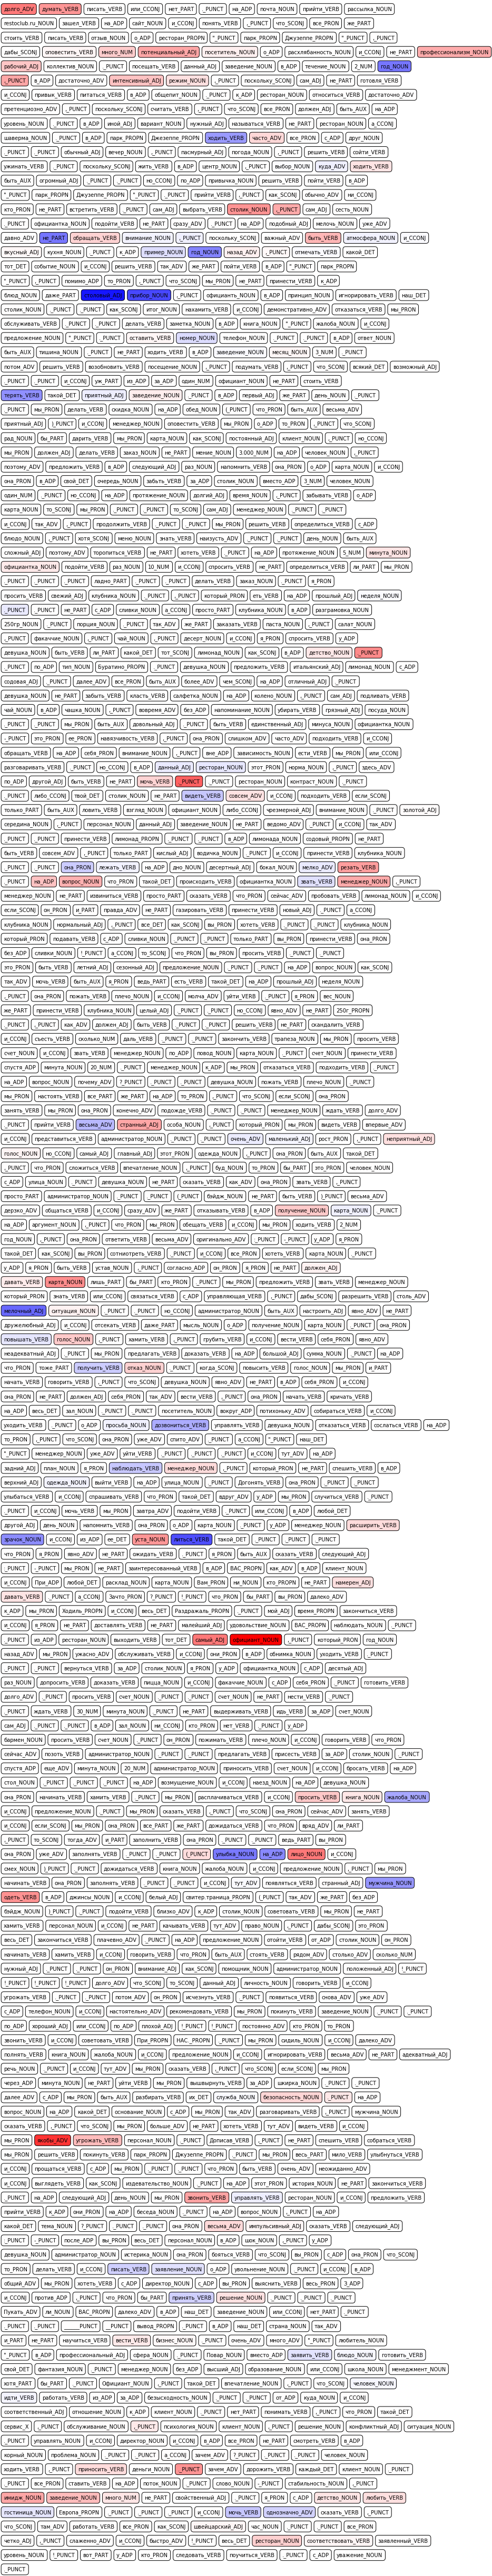

In [29]:
plot_text_heatmap(
    texts_train[100],
    a[0][0]
)

Review(id=0): все_PRON здоровый_ADJ ,_PUNCT много_NUM все_PRON понравиться_VERB атмосфера_NOUN ._PUNCT а_CCONJ вот_PART официант_NOUN не_PART очень_ADV расторопный_ADJ ._PUNCT даже_PART ког_NOUN много_ADV народ_NOUN ,_PUNCT один_NUM -_PUNCT два_NUM мочь_VERB тоять_VERB прислониться_VERB к_ADP стеночка_NOUN и_CCONJ озирать_VERB окрестность_NOUN ,_PUNCT не_PART замечать_VERB поднять_VERB рука_NOUN ._PUNCT кричать_VERB или_CCONJ свистеть_VERB не_PART стать_VERB ,_PUNCT хотя_SCONJ быть_VERB желание_NOUN
Review 0 (0.0680s)
Pred class : 1 ✓


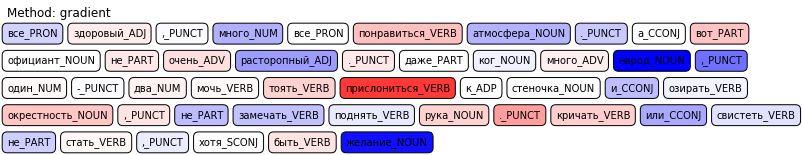

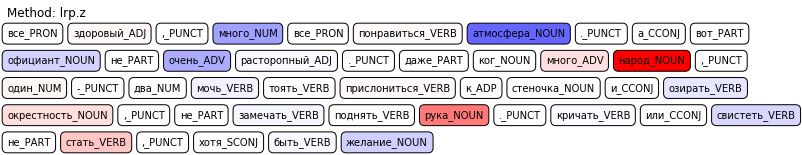

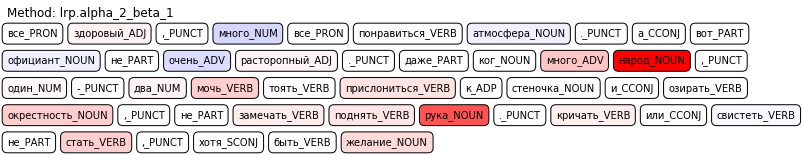

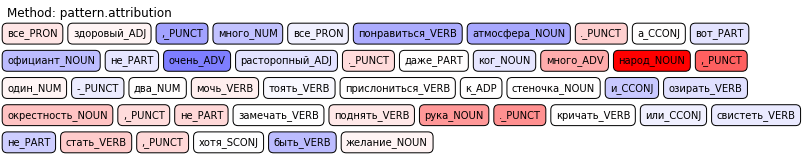

In [33]:
idx = 0
words = texts_val[idx]
    
print('Review(id=%d): %s' % (idx, ' '.join(words)))
y_true = scores_val[idx]
a, y_pred = analyze_scores(input_tensor_val, scores_val, idx)

print("Pred class : %d %s" %
      (y_pred, '✓' if y_pred == y_true else '✗ (%d)' % y_true)
      )
                            
for j, method in enumerate(methods):
    plot_text_heatmap(words, a[j].reshape(-1), title='Method: %s' % method, verbose=0)
    plt.show()
    print()